# Python Decal Project

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import matplotlib.animation as animation
import scipy as sp
from sympy import *
from scipy.integrate import solve_ivp
import pickle
import time
import os
from scipy.stats import linregress, qmc
from scipy.optimize import curve_fit
import multiprocessing as mp

np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

The Hamiltonian we want to simulate is the 2D anharmonic oscillator,

$$ H = \frac{\vec{p}^2}{2m} + \frac{1}{2}m\omega^2\vec{x}^2 + a(x^4+y^4) + 2bx^2y^2 $$

Which we get the equations of motion,

$$ \frac{dx}{dt} = \frac{p}{m} = v $$
$$ \frac{dp}{dt} = m\omega^2x $$

### What We Doin

1. Microcanonical Averaging
2. Get a general sense of what it means to be integrable and chaotic.
3. Finally, curve fitting to Lyapunov Exponents

## Microcanonical Averaging

Since we're splitting off into computing the Lyapunov spectrum (which we'll get to) for a set energy level, we want to properly sample our systems. What this is means is, is more easy to see visually. Say we want to sample the energy $E=10$. I.e, we constrain our system to be,

$$ 10 = \frac{\vec{p}^2}{2m} + \frac{1}{2}m\omega^2\vec{x}^2 + a(x^4+y^4) + 2bx^2y^2 $$

Particularly we will play with the $b$ term which either breaks or perserves integrability. So let's just set $m=\omega=a=1$. I.e,

$$ 10 = \frac{\vec{p}^2}{2} + \frac{1}{2}\vec{x}^2 + (x^4+y^4) + 2bx^2y^2 $$

In [2]:
def H2D(x1, p1, x2, p2, b):
    return (p1 * p1 + p2 * p2) / (2) + (x1 * x1 + x2 * x2) / 2 + (
            x1 * x1 * x1 * x1 + x2 * x2 * x2 * x2) + 2 * b * x1 * x1 * x2 * x2

def H2DCheck(x1, p1, x2, b):
    return (p1 * p1) / (2) + (x1 * x1 + x2 * x2) / 2 + (
            x1 * x1 * x1 * x1 + x2 * x2 * x2 * x2) + 2 * b * x1 * x1 * x2 * x2


def generateInitialConditions(b, E):
    
    count = 0
    initConditions = np.array([])
    while count < 5000:
        x1 = np.random.uniform(-5, 5)
        x2 = np.random.uniform(-5, 5)
        p1 = np.random.uniform(-5, 5)
        
        if H2DCheck(x1, p1, x2, b) <= E:
            
            p2 = np.sqrt(2 * (E - H2DCheck(x1, p1, x2, b)))
            
            if count == 0:
                initConditions = np.array([[x1, p1, x2, p2], [x1, -p1, x2, -p2]])
                count+=1 
            else:
                initConditions = np.append(initConditions, [[x1, p1, x2, p2]], axis = 0)
                initConditions = np.append(initConditions, [[x1, -p1, x2, -p2]], axis = 0)
                count+=1 
            
    return initConditions


In [3]:
E = 5
b = 6
a = 1

initialConditions = generateInitialConditions(b, E)


In [4]:
x2 = np.linspace(-2, 2, 1000)
eq1 = (-np.sqrt(-4*b*x2**2/a - 1/a +
            np.sqrt(16*E*a - 16*a**2*x2**4 - 8*a**2*x2**2 + 16*b**2*x2**4 + 8*b*x2**2)/a)/2).real
eq2 = (np.sqrt(-4*b*x2**2/a - 1/a +
           np.sqrt(16*E*a - 16*a**2*x2**4 - 8*a*x2**2 + 16*b**2*x2**4 + 8*b*x2**2)/a)/2).real

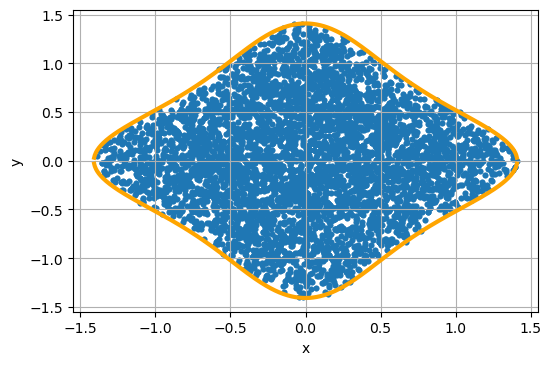

In [5]:
# Look at the distribution in position

x = initialConditions[:, 0]
px = initialConditions[:, 1]
y = initialConditions[:, 2]
py = initialConditions[:, 3]

figInitConditions_position = plt.figure(dpi = 100)
plt.scatter(x, y, s = 10)
plt.plot(x2, eq1, color = 'orange', linewidth = 3)
plt.plot(x2, eq2, color = 'orange', linewidth = 3)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()


In the plot above, we can see that our initial conditions are "approximately" distributed uniformly in our allowed region shown in the orange lines. This is what it means to *microcanonically average.* The microcanonical ensemble dictates that every initial condition has an equal probability to occur, that's why we expect a uniform distribution. However, this is not a case when we take a look at our momenta plots. However, this is not important.

# Computing Lyapunov Exponents and Simulating Trajectories

In the interest of time, we will only look at strong chaotic regime let's say, $b>20$. Anything below this, we will need to go to long time averaging which will take too much compute time. In any case, let's now compute our trajectories.

We define our derivatives and use `solve_ivp`.

In [8]:
def f(t, xp, b):
    m = 1; w= 1; a=1;
    xt1 = xp[0]
    pt1 = xp[1]
    xt2 = xp[2]
    pt2 = xp[3]

    # Derivatives

    dx1dt = pt1 / m
    dpx1dt = -m * w ** 2 * xt1 - 4 * a * xt1 ** 3 - 4 * b * xt1 * xt2 ** 2
    dx2dt = pt2 / m
    dpx2dt = -m * w ** 2 * xt2 - 4 * a * xt2 ** 3 - 4 * b * xt1 ** 2 * xt2

    return [dx1dt, dpx1dt, dx2dt, dpx2dt]

def genData(min, max, xpxp0a, f, tmax, t, b, E):
    
    r1r2 = []
    count = 0
    print(min, max)
    for j in range(min, max):
        print('Initial Condition:',j)
        delta = 1e-8
        xpxp0 = xpxp0a[j]
        
        for i in range(0, 5):
            dxpxp0 = [xpxp0[0] + delta, xpxp0[1], xpxp0[2], xpxp0[3]]


            xpt = solve_ivp(f, (0, tmax), xpxp0, t_eval=t, method='DOP853', rtol=1e-8, atol=1e-8, args=(b,))
            dxpt = solve_ivp(f, (0, tmax), dxpxp0, t_eval=t, method='DOP853', rtol=1e-8, atol=1e-8, args=(b,))

            x, px, y, py = xpt.y
            xe, pxe, ye, pye = dxpt.y
            
            r1r2a = ((x-xe)**2 + (y-ye)**2)/delta**2
            
            if j == 0:
                r1r2 = r1r2a
            else:
                r1r2 = r1r2 + r1r2a
                
            count += 1
            delta = delta / 10

        
    return r1r2, count


## First Time Running:

**Run the next cell while reading this.**

Since most likely, we will not have enough time to understand the code above I will just give a quick run down of what's happening. 

1. The Lyapunov Exponent can be found from the following relation, **IF the difference between two close trajectories exponentially grows**,

$$ \Delta r \approx e^{\lambda t} $$

    This is just an experimentally found fact, there's no deeper physics. 

2. We're averaging over smaller and smaller differences of one initial condition. For example, we have the initial conditions,

$$ [1, 1, 1, 1] $$

   We just change $x$ a little bit by adding a small $\delta$, $\delta = 1*10^{-8}$. We do this 5 times by dividing $\delta$ by 10 each iteration.

3. We average over these initial conditions to show that there is indeed an exponential growth, by logging our y-scale.

4. We keep doing this by fixing our $b$ and incrementing our energy to get the Lyapunov spectra.

## Example:

### Hopefully by now, the next cell has almost finished running. But let's consider the lowest limit, $b=20$ and $E=10$ case.

### Important Notes:

1. Note `r1r2` is the non-dimensionalized difference between the two close trajectories. Explicitly,

    $$ |\Delta r|^2/\delta^2 = \frac{(r_1 - r_2)^2}{\delta^2} $$

    Don't get too hung up on this, this is literally just telling you how much we've deviated from our **original initial condition.**
    
2. While our `initConditions` contains `N=5000` initial conditions, often just using 300 or 500 samples is good enough to see a strong Lyapunov exponent.

In [7]:
initConditions = generateInitialConditions(20, 10)
dt = .001
tmax = 5 * np.pi
N = int(tmax / dt)
t = np.linspace(0, tmax, N)

solver = genData(0, 500, initConditions, f, tmax, t, 20, 10)

0 500
Initial Condition: 0
Initial Condition: 1
Initial Condition: 2
Initial Condition: 3
Initial Condition: 4
Initial Condition: 5
Initial Condition: 6
Initial Condition: 7
Initial Condition: 8
Initial Condition: 9
Initial Condition: 10
Initial Condition: 11
Initial Condition: 12
Initial Condition: 13
Initial Condition: 14
Initial Condition: 15
Initial Condition: 16
Initial Condition: 17
Initial Condition: 18
Initial Condition: 19
Initial Condition: 20
Initial Condition: 21
Initial Condition: 22
Initial Condition: 23
Initial Condition: 24
Initial Condition: 25
Initial Condition: 26
Initial Condition: 27
Initial Condition: 28
Initial Condition: 29
Initial Condition: 30
Initial Condition: 31
Initial Condition: 32
Initial Condition: 33
Initial Condition: 34
Initial Condition: 35
Initial Condition: 36
Initial Condition: 37
Initial Condition: 38
Initial Condition: 39
Initial Condition: 40
Initial Condition: 41
Initial Condition: 42
Initial Condition: 43
Initial Condition: 44
Initial Condit

Initial Condition: 361
Initial Condition: 362
Initial Condition: 363
Initial Condition: 364
Initial Condition: 365
Initial Condition: 366
Initial Condition: 367
Initial Condition: 368
Initial Condition: 369
Initial Condition: 370
Initial Condition: 371
Initial Condition: 372
Initial Condition: 373
Initial Condition: 374
Initial Condition: 375
Initial Condition: 376
Initial Condition: 377
Initial Condition: 378
Initial Condition: 379
Initial Condition: 380
Initial Condition: 381
Initial Condition: 382
Initial Condition: 383
Initial Condition: 384
Initial Condition: 385
Initial Condition: 386
Initial Condition: 387
Initial Condition: 388
Initial Condition: 389
Initial Condition: 390
Initial Condition: 391
Initial Condition: 392
Initial Condition: 393
Initial Condition: 394
Initial Condition: 395
Initial Condition: 396
Initial Condition: 397
Initial Condition: 398
Initial Condition: 399
Initial Condition: 400
Initial Condition: 401
Initial Condition: 402
Initial Condition: 403
Initial Con

In [28]:
r1r2, count = solver

print("Our difference array r1r2:", r1r2 )
print("Number of samples:", count)

Our difference array r1r2: [2.49600619e+03 2.49588567e+03 2.49552948e+03 ... 6.44650770e+26
 6.45445169e+26 6.46240538e+26]
Number of samples: 2500


Text(0, 0.5, 'r1r2')

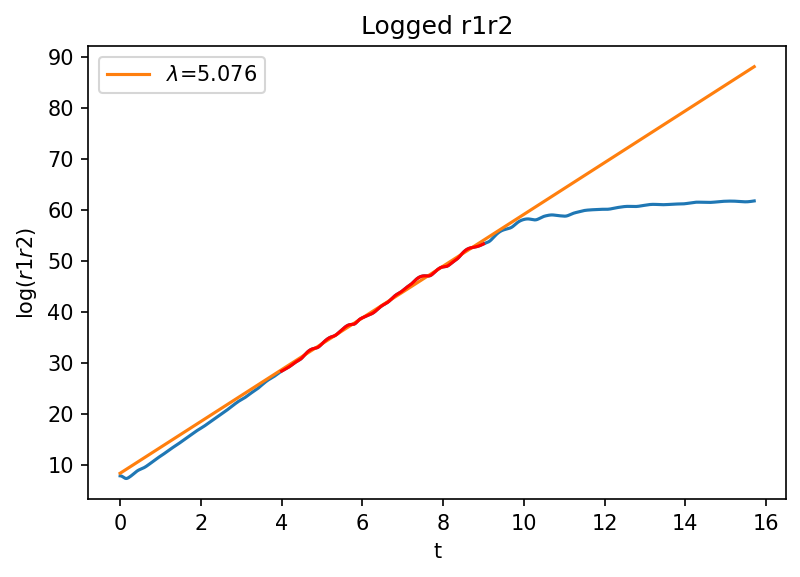

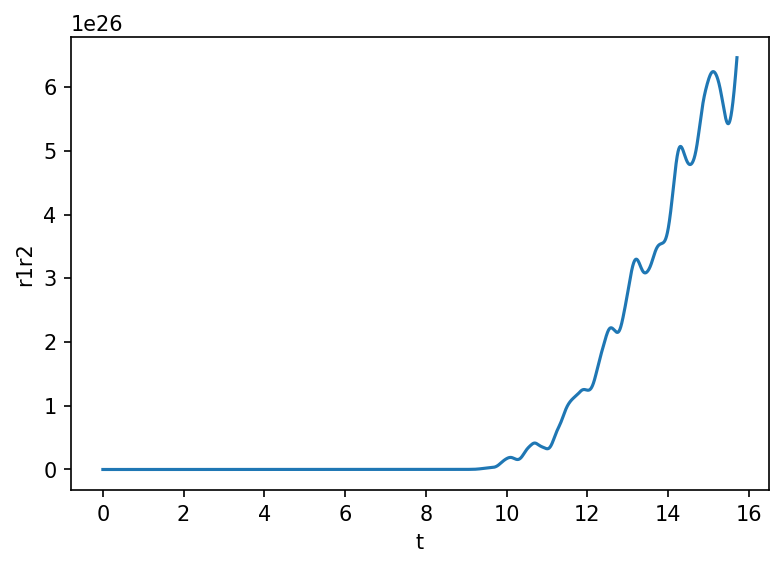

In [29]:
figlogged = plt.figure(dpi = 150)
r1r2log = np.log(r1r2)
solve = linregress(t[4000:9000], r1r2log[4000:9000])
plt.plot(t, r1r2log)
line2, = plt.plot(t, solve.intercept + solve.slope*t, label=f'$\lambda$={np.round(solve.slope, 3)}')
plt.legend()
plt.plot(t[4000:9000], r1r2log[4000:9000], color = 'red')
plt.title("Logged r1r2")
plt.xlabel('t')
plt.ylabel('$\log(r1r2)$')


fignonlogged = plt.figure(dpi=150)
plt.plot(t, r1r2)
plt.xlabel('t')
plt.ylabel('r1r2')

## We calculated a Lyapunov exponent! Yay!

Now notice, since we're taking an *average* we have to look at our `r1r2` variable and divide this by the number of samples we have. Now, I must make an important distinction in the plot above. The plot that you probably expected where we would calculate is the very last plot. I.e, just plotting `t` vs `r1r2`. However, where we want to calculate data is the log scale of `r1r2`. This idea is quite simple consider the following,

$$\log(e^{\alpha x}) = \alpha x$$

Remember the definition of the Lyapunov exponent, $|\Delta r|^2 \propto e^{\lambda t}$. If we log our data, we expect a **linear relationship** in the log scale. The slope in the logged y-scale gives us our Lyapunov exponent.

Before, we go off on our own and calculate these by ourselves there's a general way to compute the Lyapunov exponent, which I will go in depth.

### Directions to compute Lyapunov Exponent:

1. I primarily gave us the conditions that $E>10$ and $b>20$ since, if we go into lower $b$ regimes we have to compute longer times than we're currently doing. Of course, there is a chance that if we increase our $E$ that the Lyapunov exponent may not come out. Theoretically, this should be impossible since our $b$ is a large value (b dictates how chaotic our system is). **If you cannot see the Lyapunov exponent please let me know.**

2. Our `t` array should be enough for most of our cases, so you just have to play with how to best fit your slope. In the plot where I calculated the Lyapunov exponent, **the red line shows where we get an estimate of our slope**. You can of course, contain a larger range of data. However, make sure that you are only getting the linear regime. 

3. Repeat the calculations we made above by incrementing our energy in the following:

    $$ E = [10, 15, 25, 50, 100] $$
    
    So just compute the Lyapunov exponent 5 times! However, each time you calculate the Lyapunov exponent make sure you save another array such that,
    
    $$ \lambda = [\lambda_{E=10}, \lambda_{E=15}, \lambda_{E=25}, \lambda_{E=50}, \lambda_{E=100}] $$
    
    We will use this data to generate a Lyapunov spectra with varying $b$'s.
    
4. If anything is unclear, feel free to reach out!

### $b$ assignments:

To give everyone clear instructions, I'll just assign what $b$ each person should calculate,

1. Cedric: b = 50
2. Simon: b = 40
3. Leila: b = 30
4. Crystal: b = 20

Note, make sure to change $E$ in the increments we stated above. For ease, just run the next few cells to calculate your Lyapunov exponents.

In [45]:
# Don't forget to put your Lyapunov exponents here in the order of E
lyapunovArray = np.array([7.368, 8.01, 8.656, 11.193, 14.498])

Earray = np.array([10, 15, 25, 50, 100])

# Input your b

b = 30

# Solver
# Input your energy in order Earray[0], Earray[1], Earray[2], ... into the elipses.

E = Earray[0]

initConditions = generateInitialConditions(b, E)
dt = .001
tmax = 5 * np.pi
N = int(tmax / dt)
t = np.linspace(0, tmax, N)

solver = genData(0, 500, initConditions, f, tmax, t, b, E)

0 500
Initial Condition: 0
Initial Condition: 1
Initial Condition: 2
Initial Condition: 3
Initial Condition: 4
Initial Condition: 5
Initial Condition: 6
Initial Condition: 7
Initial Condition: 8
Initial Condition: 9
Initial Condition: 10
Initial Condition: 11
Initial Condition: 12
Initial Condition: 13
Initial Condition: 14
Initial Condition: 15
Initial Condition: 16
Initial Condition: 17
Initial Condition: 18
Initial Condition: 19
Initial Condition: 20
Initial Condition: 21
Initial Condition: 22
Initial Condition: 23
Initial Condition: 24
Initial Condition: 25
Initial Condition: 26
Initial Condition: 27
Initial Condition: 28
Initial Condition: 29
Initial Condition: 30
Initial Condition: 31
Initial Condition: 32
Initial Condition: 33
Initial Condition: 34
Initial Condition: 35
Initial Condition: 36
Initial Condition: 37
Initial Condition: 38
Initial Condition: 39
Initial Condition: 40
Initial Condition: 41
Initial Condition: 42
Initial Condition: 43
Initial Condition: 44
Initial Condit

KeyboardInterrupt: 

In [41]:
r1r2, count = solver

print("Our difference array r1r2:", r1r2 )
print("Number of samples:", count)

Our difference array r1r2: [2.49602579e+03 2.49569432e+03 2.49468737e+03 ... 2.86057793e+27
 2.86202256e+27 2.86347593e+27]
Number of samples: 2500


Text(0, 0.5, '$\\log(r1r2)$')

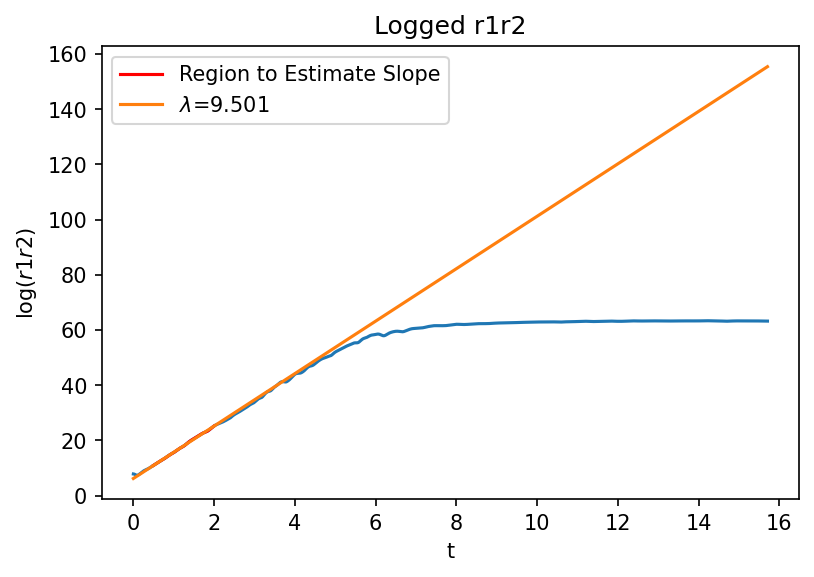

In [43]:
figlogged = plt.figure(dpi = 150)

#Logging data
r1r2log = np.log(r1r2)

plt.plot(t, r1r2log)

# Find where the best linear correlation is first by varying [begin_fit:end_fit]
begin_fit = 500
end_fit = 2000
plt.plot(t[begin_fit:end_fit], r1r2log[begin_fit:end_fit], color = 'red', label = 'Region to Estimate Slope')


# When you're ready, uncomment solve and line2 to find the best slope.

solve = linregress(t[begin_fit:end_fit], r1r2log[begin_fit:end_fit])
line2, = plt.plot(t, solve.intercept + solve.slope*t, label=f'$\lambda$={np.round(solve.slope, 3)}')


plt.legend()

plt.title("Logged r1r2")
plt.xlabel('t')
plt.ylabel('$\log(r1r2)$')


# Don't forget to save your Lyapunov exponent!

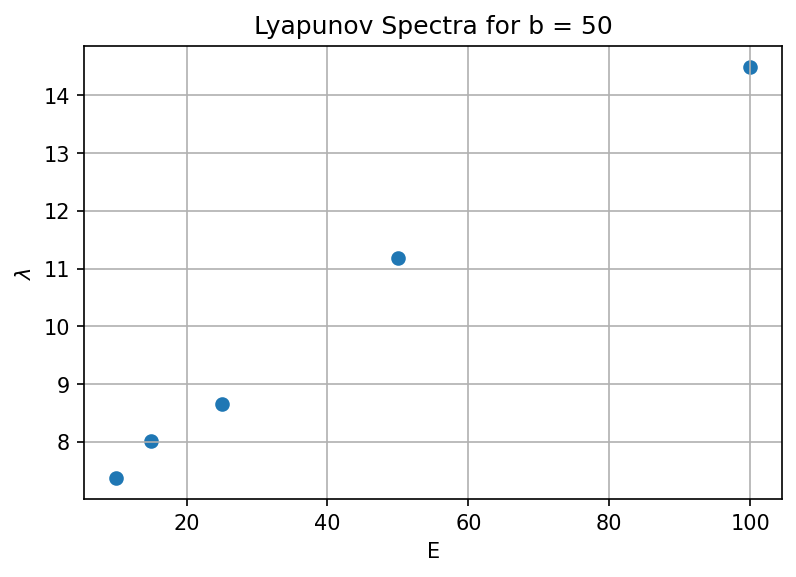

In [10]:
# Plotting Lyapunov spectra

fig_spectra = plt.figure(dpi = 150)
plt.title(f'Lyapunov Spectra for b = {b}')
plt.scatter(Earray, lyapunovArray)
plt.xlabel('E')
plt.ylabel('$\lambda$')
plt.grid()

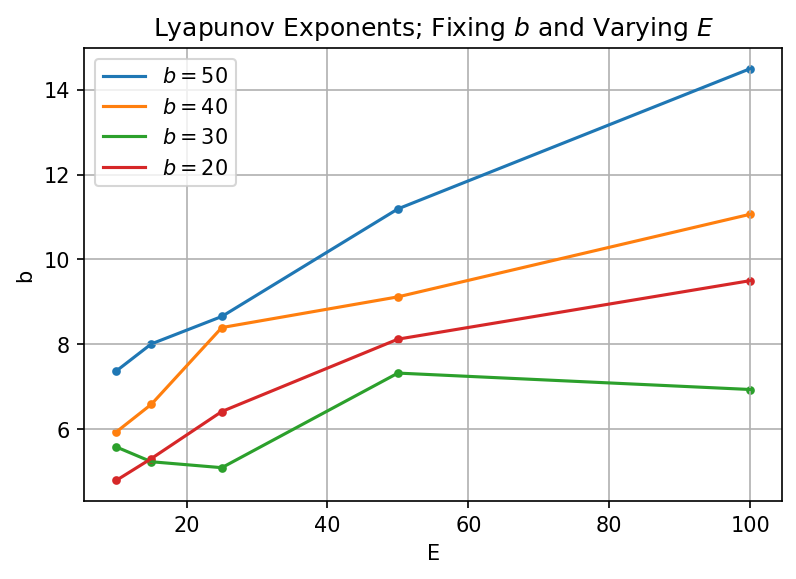

In [49]:
lyapunovArrayb_50 = np.array([7.368, 8.01, 8.656, 11.193, 14.498])
lyapunovArrayb_40 = np.array([5.931, 6.586, 8.395, 9.119, 11.066])
lyapunovArrayb_30 = np.array([5.582, 5.232, 5.092, 7.322, 6.935])
lyapunovArrayb_20 = np.array([4.79, 5.307, 6.416, 8.122, 9.501])

fig_all_spectra = plt.figure(dpi = 150)

plt.grid()
plt.scatter(Earray, lyapunovArrayb_50, s = 10)
plt.scatter(Earray, lyapunovArrayb_40,s = 10)
plt.scatter(Earray, lyapunovArrayb_30,s = 10)
plt.scatter(Earray, lyapunovArrayb_20, s= 10)

plt.plot(Earray, lyapunovArrayb_50, label = '$b=50$')
plt.plot(Earray, lyapunovArrayb_40, label = '$b=40$')
plt.plot(Earray, lyapunovArrayb_30, label = '$b=30$')
plt.plot(Earray, lyapunovArrayb_20, label = '$b=20$')

plt.title('Lyapunov Exponents; Fixing $b$ and Varying $E$')
plt.xlabel('E')
plt.ylabel('b')

plt.legend()

# Exponential Separation Between Two Close Trajectories

What do we mean when two close trajectories exponentially separate from each other. We can animate what this means.

In [6]:
from matplotlib.animation import FFMpegWriter

In [1]:
def genData_animate(min, max, xpxp0a, f, tmax, t, b, E):
    

    for j in range(min, max):
        print('Initial Condition:',j)
        delta = 1e-8
        xpxp0 = xpxp0a[j]
        
        for i in range(0, 1):
            dxpxp0 = [xpxp0[0] + delta, xpxp0[1], xpxp0[2], xpxp0[3]]


            xpt = solve_ivp(f, (0, tmax), xpxp0, t_eval=t, method='DOP853', rtol=1e-8, atol=1e-8, args=(b,))
            dxpt = solve_ivp(f, (0, tmax), dxpxp0, t_eval=t, method='DOP853', rtol=1e-8, atol=1e-8, args=(b,))

            x, px, y, py = xpt.y
            xe, pxe, ye, pye = dxpt.y
            
        
    return xpt, dxpt

In [30]:
E = 10
b = 20
dt = .001
tmax = 5 * np.pi
N = int(tmax / dt)
t = np.linspace(0, tmax, N)

initialConditions = generateInitialConditions(b, E)

xpt, dxpt = genData_animate(0, 1, initialConditions, f, tmax, t, b, E)

Initial Condition: 0


In [31]:
t.size

15707

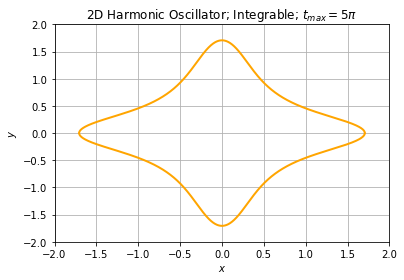

MovieWriter imagemagick unavailable; using Pillow instead.


In [32]:
En = 10
b = 20
a = 1
plt.rcParams['text.usetex'] = False


fig1 = plt.figure()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title(r"2D Harmonic Oscillator; Integrable; $t_{max}=5\pi$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
graph1, = plt.plot([], [], 'o', color='blue')
trace1, = plt.plot([], [], ',-', color='blue', lw=1, ms=2)

graph2, = plt.plot([], [], 'o', color='red')
trace2, = plt.plot([], [], ',-', color='red', lw=1, ms=2)

plt.grid()
pt = 0

x1, p1, x21, p2 = xpt.y
dx1, dp1, dx2, dp2 = dxpt.y

x2 = np.linspace(-4, 4, 30000)

eq1 = (-np.sqrt(-4*b*x2**2/a - 1/a +
            np.sqrt(16*E*a - 16*a**2*x2**4 - 8*a**2*x2**2 + 16*b**2*x2**4 + 8*b*x2**2)/a)/2).real
eq2 = (np.sqrt(-4*b*x2**2/a - 1/a +
           np.sqrt(16*E*a - 16*a**2*x2**4 - 8*a*x2**2 + 16*b**2*x2**4 + 8*b*x2**2)/a)/2).real


plt.plot(x2, eq1, linewidth=2, color='orange')
plt.plot(x2, eq2, linewidth=2, color='orange')

i=0

start = 0
stop = 15707
                                  

x1Anim = x1[start:stop]
x2Anim = x2[start:stop]

dx1Anim = dx1[start:stop]
dx2Anim = dx2[start:stop]

    
def animate(i):
    graph1.set_data(x1[i*20], x21[i*20])
    trace1.set_data(x1[:i*20], x21[:i*20])
    
    graph2.set_data(dx1[i*20], dx2[i*20])
    trace2.set_data(dx1[:i*20], dx2[:i*20],)
    
    return graph1, trace1, graph2, trace2

ani = animation.FuncAnimation(fig1, animate, frames=300, interval=1, repeat=False)


plt.show()
ani.save('animation.gif', writer='imagemagick', fps=30, dpi = 200)

If you open the `animation.gif` file in your directory, you will see what it means to be exponentially diverging. 